In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("nih-chest-xrays/sample")

print("Path to dataset files:", path)

/Users/carlkaziboni/anaconda3/envs/xraydetection/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


100%|██████████| 4.20G/4.20G [02:04<00:00, 36.3MB/s]

Extracting files...


Path to dataset files: /Users/carlkaziboni/.cache/kagglehub/datasets/nih-chest-xrays/sample/versions/4


In [ ]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [ ]:
# Load sample labels
labels = pd.read_csv(os.path.join("sample", "sample_labels.csv"))
labels

In [11]:
# Get unique labels
unique_labels = labels['Finding Labels'].unique()
#print("Unique labels:", unique_labels)

# Split unique findings into set
findings_set = set()
for finding in unique_labels:
    if finding not in findings_set:
        for item in finding.split('|'):
            findings_set.add(item.strip())

# Print unique findings
print("Unique findings:", findings_set)

Unique findings: {'Consolidation', 'Atelectasis', 'Nodule', 'Hernia', 'Edema', 'Effusion', 'Cardiomegaly', 'Mass', 'Emphysema', 'Fibrosis', 'Pleural_Thickening', 'No Finding', 'Pneumonia', 'Infiltration', 'Pneumothorax'}


In [13]:
# Create new folder for resized images
resized_folder = "resized_images"
if not os.path.exists(resized_folder):
    os.makedirs(resized_folder)

# Create folders for each finding
for finding in findings_set:
    finding_folder = os.path.join(resized_folder, finding)
    if not os.path.exists(finding_folder):
        os.makedirs(finding_folder)

# Resize images and save to respective folders
for index, row in labels.iterrows():
    image_path = os.path.join("sample", "images", row['Image Index'])
    if os.path.exists(image_path):
        # Read the image
        img = cv2.imread(image_path)
        if img is not None:
            # Resize the image to 224x224
            resized_img = cv2.resize(img, (224, 224))
            
            # Save the resized image to the respective finding folder
            for finding in row['Finding Labels'].split('|'):
                finding = finding.strip()
                if finding in findings_set:
                    save_path = os.path.join(resized_folder, finding, row['Image Index'])
                    cv2.imwrite(save_path, resized_img)

In [15]:
# Split the dataset into training and validation sets for each finding
train_val_split = {}
for finding in findings_set:
    finding_folder = os.path.join(resized_folder, finding)
    if os.path.exists(finding_folder):
        images = [f for f in os.listdir(finding_folder) if f.endswith('.png') or f.endswith('.jpg')]
        train_images, val_images = train_test_split(images, test_size=0.2, random_state=42)
        train_val_split[finding] = {
            'train': train_images,
            'val': val_images
        }


In [56]:
class MultiLabelDataGenerator(Sequence):
    def __init__(self, dataframe, image_dir, findings_set, batch_size, target_size, shuffle=True):
        """
        Custom data generator for multi-label classification.

        Args:
            dataframe (pd.DataFrame): DataFrame containing image file names and labels.
            image_dir (str): Directory containing the images.
            findings_set (set): Set of unique findings.
            batch_size (int): Number of samples per batch.
            target_size (tuple): Target size for resizing images (height, width).
            shuffle (bool): Whether to shuffle the data after each epoch.
        """
        self.dataframe = dataframe
        self.image_dir = image_dir
        self.findings_set = findings_set
        self.batch_size = batch_size
        self.target_size = target_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(self.dataframe))
        self.finding_to_index = {finding: idx for idx, finding in enumerate(findings_set)}
        self.on_epoch_end()

    def __len__(self):
        """Number of batches per epoch."""
        return int(np.ceil(len(self.dataframe) / self.batch_size))

    def __getitem__(self, index):
        """Generate one batch of data."""
        batch_indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        batch_data = self.dataframe.iloc[batch_indexes]

        images, labels = self.__data_generation(batch_data)
        return images, labels

    def on_epoch_end(self):
        """Shuffle data at the end of each epoch."""
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __data_generation(self, batch_data):
        """Generate data for the batch."""
        images = []
        labels = []

        for _, row in batch_data.iterrows():
            # Load and preprocess the image
            img_path = os.path.join(self.image_dir, row['Image Index'])
            img = load_img(img_path, target_size=self.target_size)
            img = img_to_array(img) / 255.0  # Normalize to [0, 1]
            images.append(img)

            # Multi-hot encode the labels
            label_vector = np.zeros(len(self.findings_set), dtype=int)
            for finding in row['Finding Labels'].split('|'):
                finding = finding.strip()
                if finding in self.finding_to_index:
                    label_vector[self.finding_to_index[finding]] = 1
            labels.append(label_vector)

        return np.array(images), np.array(labels)

In [57]:
# Create model
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(224, 224, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(len(findings_set), activation='sigmoid')
])

# Compile model

model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])

model.build(input_shape=(None, 224, 224, 3))

model.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_27 (Conv2D)              │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_27 (MaxPooling2D) │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_28 (MaxPooling2D) │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_29 (MaxPooling2D) │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_9 (Flatten)             │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 256)            │    25,690,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 15)             │         3,855 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,787,471 (98.37 MB)

 Trainable params: 25,787,471 (98.37 MB)

 Non-trainable params: 0 (0.00 B)

In [58]:
# Prepare the dataset
train_df, val_df = train_test_split(labels, test_size=0.2, random_state=42)

# Create the data generators
batch_size = 32
target_size = (224, 224)
train_generator = MultiLabelDataGenerator(train_df, "sample/images", findings_set, batch_size, target_size)
val_generator = MultiLabelDataGenerator(val_df, "sample/images", findings_set, batch_size, target_size)

# Train the model
model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10
)

/Users/carlkaziboni/anaconda3/envs/xraydetection/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 83s 578ms/step - accuracy: 0.4919 - loss: 0.2523 - val_accuracy: 0.5401 - val_loss: 0.2195
Epoch 2/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 92s 655ms/step - accuracy: 0.5397 - loss: 0.2144 - val_accuracy: 0.5285 - val_loss: 0.2105
Epoch 3/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 87s 612ms/step - accuracy: 0.5311 - loss: 0.2038 - val_accuracy: 0.5276 - val_loss: 0.2162
Epoch 4/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 106s 747ms/step - accuracy: 0.5625 - loss: 0.1876 - val_accuracy: 0.4626 - val_loss: 0.2237
Epoch 5/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 129s 915ms/step - accuracy: 0.5970 - loss: 0.1660 - val_accuracy: 0.5053 - val_loss: 0.2382
Epoch 6/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 101s 714ms/step - accuracy: 0.6724 - loss: 0.1343 - val_accuracy: 0.4510 - val_loss: 0.2940
Epoch 7/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 94s 662ms/step - accuracy: 0.7267 - loss: 0.0990 - val_accuracy: 0.4305 - val_loss: 0.3447
Epoch 8/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 101s 718ms/step - accuracy: 0.7907 - los

In [59]:
# validate the model
val_loss, val_accuracy = model.evaluate(val_generator)
print(f"Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}")

36/36 ━━━━━━━━━━━━━━━━━━━━ 10s 271ms/step - accuracy: 0.4131 - loss: 0.7180
Validation Loss: 0.7492535710334778, Validation Accuracy: 0.4126559793949127


In [61]:
# save the model
model.save("xray_detection_model.keras")

In [62]:
model.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_27 (Conv2D)              │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_27 (MaxPooling2D) │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_28 (MaxPooling2D) │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_29 (MaxPooling2D) │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_9 (Flatten)             │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 256)            │    25,690,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 15)             │         3,855 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 77,362,415 (295.11 MB)

 Trainable params: 25,787,471 (98.37 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 51,574,944 (196.74 MB)

In [213]:
# Multi-label prediction example
sample_image_path = os.path.join("sample", "images", "00000359_002.png")
sample_img = load_img(sample_image_path, target_size=(224, 224))
sample_img_array = img_to_array(sample_img) / 255.0  # Normalize to
sample_img_array = np.expand_dims(sample_img_array, axis=0)  # Add batch dimension
predictions = model.predict(sample_img_array)
predicted_labels = [list(findings_set)[i] for i in range(len(predictions[0])) if predictions[0][i] > 0.5]
print("Predicted labels:", predicted_labels)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Predicted labels: ['Infiltration']


In [192]:
# Grad CAM visualization
import cv2
import numpy as np
import matplotlib.pyplot as plt

def get_grad_cam_heatmap(model, img_array, layer_name, pred_index=None):
    """
    Generate Grad CAM heatmap for a given image and model layer.
    
    Args:
        model (tf.keras.Model): Trained model.
        img_array (np.ndarray): Preprocessed image array.
        layer_name (str): Name of the convolutional layer to visualize.
    
    Returns:
        np.ndarray: Heatmap of the Grad CAM.
    """
    # Ensure input is a TensorFlow tensor
    if isinstance(img_array, np.ndarray):
        img_array = tf.convert_to_tensor(img_array, dtype=tf.float32)

    assert isinstance(img_array, tf.Tensor), "img_array must be a TensorFlow tensor"
    assert len(img_array.shape) == 4, "img_array must have shape (1, height, width, channels)"

    # Forward pass to get the correct symbolic tensors
    with tf.GradientTape() as tape:
        # Watch the input
        tape.watch(img_array)

        # Forward pass through the model
        outputs = {}
        x = img_array
        for layer in model.layers:
            x = layer(x)
            outputs[layer.name] = x
            if layer.name == layer_name:
                conv_output = x

        predictions = x
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        loss = predictions[:, pred_index]

    # Compute gradients
    grads = tape.gradient(loss, conv_output)[0]
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1))

    conv_output = conv_output[0]
    heatmap = conv_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)

    return heatmap.numpy()

In [201]:
def display_heatmap(heatmap, img_array, alpha=0.4):
    """
    Overlay the Grad-CAM heatmap on the original image and display it.

    Args:
        heatmap (np.ndarray): Heatmap to overlay (2D array).
        img_array (np.ndarray): Original image array (batch of 1).
        alpha (float): Transparency factor for the overlay.
    """
    # Ensure image is in uint8 format and shape (H, W, 3)
    img = img_array[0]
    if img.max() <= 1.0:
        img = (img * 255).astype(np.uint8)
    else:
        img = img.astype(np.uint8)

    # Resize heatmap to match image size
    heatmap_resized = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap_resized = np.uint8(255 * heatmap_resized)
    heatmap_color = cv2.applyColorMap(heatmap_resized, cv2.COLORMAP_JET)

    # Overlay heatmap on image
    superimposed_img = cv2.addWeighted(img, 1 - alpha, heatmap_color, alpha, 0)

    # Display
    plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()


In [202]:
model.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_27 (Conv2D)              │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_27 (MaxPooling2D) │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_28 (MaxPooling2D) │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_29 (MaxPooling2D) │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_9 (Flatten)             │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 256)            │    25,690,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 15)             │         3,855 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 77,362,415 (295.11 MB)

 Trainable params: 25,787,471 (98.37 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 51,574,944 (196.74 MB)

In [210]:
print(sample_img_array.shape)
print(sample_img_array.dtype)
print([layer.name for layer in model.layers])
print(model.inputs)
print(type(sample_img_array))

(1, 224, 224, 3)
float32
['conv2d_27', 'max_pooling2d_27', 'conv2d_28', 'max_pooling2d_28', 'conv2d_29', 'max_pooling2d_29', 'flatten_9', 'dense_18', 'dense_19']
[<KerasTensor shape=(None, 224, 224, 3), dtype=float32, sparse=False, ragged=False, name=keras_tensor_117>]
<class 'numpy.ndarray'>


In [211]:
print([layer.name for layer in model.layers])
print(model.get_layer('conv2d_29').output)


['conv2d_27', 'max_pooling2d_27', 'conv2d_28', 'max_pooling2d_28', 'conv2d_29', 'max_pooling2d_29', 'flatten_9', 'dense_18', 'dense_19']
<KerasTensor shape=(None, 56, 56, 128), dtype=float32, sparse=False, ragged=False, name=keras_tensor_122>


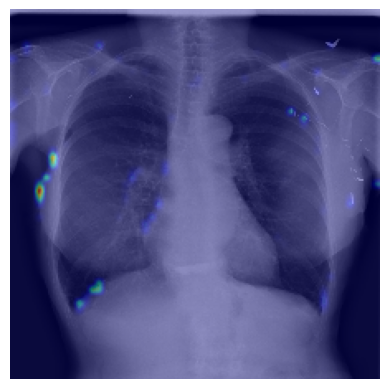

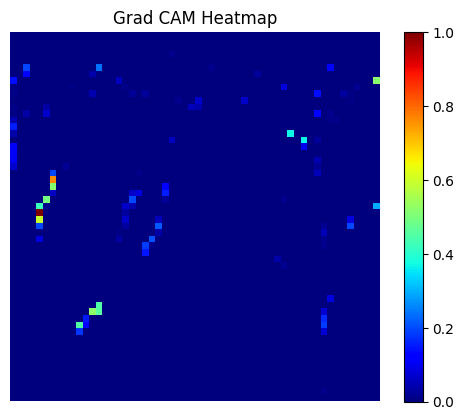

In [214]:
layer_name = 'conv2d_29'
heatmap = get_grad_cam_heatmap(model, sample_img_array, layer_name)
display_heatmap(heatmap, sample_img_array)

plt.imshow(heatmap, cmap='jet')
plt.colorbar()
plt.title('Grad CAM Heatmap')
plt.axis('off')
plt.show()
